# Data (+Stats) for Paper

In [1]:
#import libraries
import pandas as pd
import numpy as np
#import netCDF4
import xarray as xr

# import matplotlib
# import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec

# import scipy
# import scipy.stats
# from scipy import signal
# from scipy.signal import butter, lfilter, sosfilt

# import cartopy
# import cartopy.crs as ccrs
# from cartopy.util import add_cyclic_point
# import cartopy.feature as cfeature

# import seaborn as sns

In [2]:
#set up for wrf and era
variables_wrf = ['T2', 'SWDNT']
variables_era = ['mx2t']
variables_era_gph = ['z']
variables_wrf_gph = ['gph', 'temp']
temperature_variables_era = ["t2m"]

In [3]:
#functions
def records_area(records_broken, model_june, model, threshold, area_path, land_ocean_mask,lat1,lat2,lon1,lon2):
    area_dat = xr.open_dataset(area_path)
    area = area_dat.cell_area.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)) #find PNW
    mask = land_ocean_mask.sel(latitude = slice(lat1,lat2), longitude = slice(lon1,lon2)) #find PNW
    #find area
    records = (records_broken - (model_june-model)).sel(latitude = slice(lat1,lat2), longitude = slice(lon1,lon2)) #find PNW.values
    records_land = mask.values*records.copy()
    #make normalised map of places (not ocean) where records were broken
    plot = records_land/records_land
    #calcualte area where records were broken
    area_rev = area.reindex(latitude=list(reversed(area.latitude)))
    area_above_threshold = area_rev.where(records_land>threshold,0).sum()/(1000**2) #in km^2
    return(area_above_threshold, plot)

### Load Data

In [3]:
#time indices
indices = np.arange(57,153+1)
filepath = '/scratch/st-rwhite01-1/lualawi/insol/insol/'
#ERA for records
with xr.open_dataset(filepath+"era5_t2m_hourly_1940-2021_PNW_JJA.nc") as era_reg:
    era_dailymax = era_reg.resample(time = "1D").max()
    #find daily maximum and find the 2021 event in era5
    era_daily_max_PNW = era_dailymax.sel(latitude = slice(40,65), longitude = slice(-140,-100), 
                       time = slice("1940-01-01T00:00:00.000000000", "2021-06-01T00:00:00.000000000")).t2m.max(dim = "time")
    era_test_hw = era_dailymax.sel(latitude = slice(40,65), longitude = slice(-140, -100), 
                       time = slice("2021-06-26T00:00:00.000000000", "2021-06-30T00:00:00.000000000")).t2m.max(dim = "time")

In [97]:
##### MAIN WRF RUNS (REGRIDDED FOR RECORDS) #####
with xr.open_dataset(filepath+"new_dat/BIAS_FIXED/rrtmg_radiation/june_d02_timemerge_rrtmg_regridera2d.nc") as june_2d:
    weights = np.cos(np.deg2rad(june_2d.sel(latitude = slice(65,40)).latitude))
    weighted_weights = weights/np.mean(weights)
    
    #grab june data for maps and timeseries
    june2d_bc = june_2d.sel(latitude = slice(65,40), longitude = slice(-140, -100), XTIME = june_2d.XTIME[indices])
    
    june2d_bcw = june2d_bc.groupby('latitude')*weighted_weights
    junedata_weighted = june2d_bcw.mean(dim = ['latitude', 'longitude']).T2
    
with xr.open_dataset(filepath+"new_dat/BIAS_FIXED/rrtmg_radiation/jul_d02_timemerge_rrtmg_regridera2d.nc") as july_2d:
    #grab july data for maps and timeseries
    july2d_bc = july_2d.sel(latitude = slice(65,40), longitude = slice(-140, -100), XTIME = july_2d.XTIME[indices])
    
    july2d_bcw = july2d_bc.groupby('latitude')*weighted_weights
    julydata_weighted = july2d_bcw.mean(dim = ['latitude', 'longitude']).T2

with xr.open_dataset(filepath+"new_dat/BIAS_FIXED/rrtmg_radiation/aug_d02_timemerge_rrtmg_regridera2d.nc") as aug_2d:
    #grab june data for maps and timeseries
    aug2d_bc = aug_2d.sel(latitude = slice(65,40), longitude = slice(-140, -100), XTIME = aug_2d.XTIME[indices])
    aug2d_bcw = aug2d_bc.groupby('latitude')*weighted_weights
    augdata_weighted = aug2d_bcw.mean(dim = ['latitude', 'longitude']).T2

In [69]:
#mask for records
mask_file = xr.open_dataset(filepath+'better_mask_regrid.nc')
mask = (mask_file/mask_file).sel(latitude = slice(40,65), longitude = slice(-140, -100)).mean(dim = "time").t2m

In [10]:
#DATA FOR SENSITIVITY STUDIES
#Initialisation Date
with xr.open_dataset(filepath+'sensitivity/june_minus2_d02_timemerge_regridera2d.nc') as june_minus2:
    june_minus2T = june_minus2.sel(latitude = slice(65,40), longitude = slice(-140, -100), XTIME = june_minus2.XTIME[indices+48]).T2
    
with xr.open_dataset(filepath+'sensitivity/aug_minus2_d02_timemerge_regridera2d.nc') as aug_minus2:
    aug_minus2T = aug_minus2.sel(latitude = slice(65,40), longitude = slice(-140, -100), XTIME = aug_minus2.XTIME[indices+48]).T2

#CAM    
with xr.open_dataset(filepath+"new_dat/BIAS_FIXED/cam_radiation/june_d02_timemerge_cam_regridera.nc") as june_cam:
    june_camT = june_cam.sel(latitude = slice(65,40), longitude = slice(-140, -100), XTIME = june_cam.XTIME[indices]).T2
    
with xr.open_dataset(filepath+"new_dat/BIAS_FIXED/cam_radiation/aug_d02_timemerge_cam_regridera.nc") as aug_cam:
    aug_camT = aug_cam.sel(latitude = slice(65,40), longitude = slice(-140, -100), XTIME = aug_cam.XTIME[indices]).T2
    
#NOAH LSM
with xr.open_dataset(filepath+"sensitivity/june_oldNOAHLSM-rrtmg_d02_timemerge_regridera2d.nc") as june_lsm:
    june_lsmT = june_lsm.sel(latitude = slice(65,40), longitude = slice(-140, -100), XTIME = june_lsm.XTIME[indices]).T2
    
with xr.open_dataset(filepath+"sensitivity/aug_oldNOAHLSM-rrtmg_d02_timemerge_regridera2d.nc") as aug_lsm:
    aug_lsmT = aug_lsm.sel(latitude = slice(65,40), longitude = slice(-140, -100), XTIME = aug_lsm.XTIME[indices]).T2

# #3D DATA
june = xr.open_dataset(filepath+'new_dat/BIAS_FIXED/rrtmg_radiation/june_d02_reproj_rrtmg_regrid_3d.nc')
july = xr.open_dataset(filepath+'new_dat/BIAS_FIXED/rrtmg_radiation/july_d02_reproj_rrtmg_regrid_3d.nc')
aug = xr.open_dataset(filepath+'new_dat/BIAS_FIXED/rrtmg_radiation/aug_d02_reproj_rrtmg_regrid_3d.nc')

sens_3d = xr.open_dataset(filepath+'new_dat/BIAS_FIXED/cam_radiation/june_d02_reproj_cam_regrid_3d.nc')


### Temperatures (Max and Mean)

In [102]:
## Main Runs
lat1 = 48
lat2 = 56
lon1 = 236 - 360
lon2 = 242 - 360

#mean temperature
june_T = june2d_bc.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).T2
weights = np.cos(np.deg2rad(june_T.latitude))
weighted_weights = weights/np.mean(weights)
    
temp = june_T.groupby('latitude')*weighted_weights
june_meanT = temp.mean(dim = ['latitude', 'longitude','XTIME'])

temp = (july2d_bc.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).T2).groupby('latitude')*weighted_weights
july_meanT = temp.mean(dim = ['latitude', 'longitude','XTIME'])

temp = (aug2d_bc.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).T2).groupby('latitude')*weighted_weights
aug_meanT = temp.mean(dim = ['latitude', 'longitude','XTIME'])


print(f'Area MEAN T: Control: {round(float(june_meanT.values),4)}, +30day: {round(float(july_meanT.values),4)}, +60day: {round(float(aug_meanT.values),4)}')
print(f'Differences in Area MEAN T: +30day: {round(float(june_meanT.values - july_meanT.values),4)}, +60day: {round(float(june_meanT.values - aug_meanT.values),4)}')



#heatwave maximum temperature  
temp = (june2d_bc.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).T2).groupby('latitude')*weighted_weights
june_TX = temp.mean(dim = ['latitude', 'longitude']).max(dim='XTIME')

temp = (july2d_bc.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).T2).groupby('latitude')*weighted_weights
july_TX = temp.mean(dim = ['latitude', 'longitude']).max(dim='XTIME')

temp = (aug2d_bc.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).T2).groupby('latitude')*weighted_weights
aug_TX = temp.mean(dim = ['latitude', 'longitude']).max(dim='XTIME')


print(f'Area MEAN TX: Control: {round(float(june_TX.values),4)}, +30day: {round(float(july_TX.values),4)}, +60day: {round(float(aug_TX.values),4)}')
print(f'Differences in Area MEAN TX: +30day: {round(float(june_TX.values - july_TX.values),4)}, +60day: {round(float(june_TX.values - aug_TX.values),4)}')


#heatwave maximum temperature  
temp = (june2d_bc.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).T2).groupby('latitude')*weighted_weights
june_TXX = temp.max(dim = ['latitude', 'longitude']).max(dim='XTIME')

temp = (july2d_bc.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).T2).groupby('latitude')*weighted_weights
july_TXX = temp.max(dim = ['latitude', 'longitude']).max(dim='XTIME')

temp = (aug2d_bc.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).T2).groupby('latitude')*weighted_weights
aug_TXX = temp.max(dim = ['latitude', 'longitude']).max(dim='XTIME')


print(f'Area MAX TX: Control: {round(float(june_TXX.values),4)}, +30day: {round(float(july_TXX.values),4)}, +60day: {round(float(aug_TXX.values),4)}')
print(f'Differences in Area MAX TX: +30day: {round(float(june_TXX - july_TXX.values),4)}, +60day: {round(float(june_TXX - aug_TXX.values),4)}')



Area MEAN T: Control: 300.3737, +30day: 298.8914, +60day: 295.5611
Differences in Area MEAN T: +30day: 1.4824, +60day: 4.8126
Area MEAN TX: Control: 308.7329, +30day: 307.8606, +60day: 304.7537
Differences in Area MEAN TX: +30day: 0.8723, +60day: 3.9792
Area MAX TX: Control: 347.9872, +30day: 345.9691, +60day: 344.6182
Differences in Area MAX TX: +30day: 2.018, +60day: 3.3689


In [103]:
## Sensitivity to Heatwave box definition: Main Runs
lat1 = 45
lat2 = 52
lon1 = 237 - 360
lon2 = 241 - 360

#mean temperature
june_T = june2d_bc.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).T2
weights = np.cos(np.deg2rad(june_T.latitude))
weighted_weights = weights/np.mean(weights)
    
temp = june_T.groupby('latitude')*weighted_weights
june_meanT = temp.mean(dim = ['latitude', 'longitude','XTIME'])

temp = (july2d_bc.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).T2).groupby('latitude')*weighted_weights
july_meanT = temp.mean(dim = ['latitude', 'longitude','XTIME'])

temp = (aug2d_bc.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).T2).groupby('latitude')*weighted_weights
aug_meanT = temp.mean(dim = ['latitude', 'longitude','XTIME'])


print(f'Area MEAN T: Control: {round(float(june_meanT.values),4)}, +30day: {round(float(july_meanT.values),4)}, +60day: {round(float(aug_meanT.values),4)}')
print(f'Differences in Area MEAN T: +30day: {round(float(june_meanT.values - july_meanT.values),4)}, +60day: {round(float(june_meanT.values - aug_meanT.values),4)}')



#heatwave maximum temperature  
temp = (june2d_bc.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).T2).groupby('latitude')*weighted_weights
june_TX = temp.mean(dim = ['latitude', 'longitude']).max(dim='XTIME')

temp = (july2d_bc.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).T2).groupby('latitude')*weighted_weights
july_TX = temp.mean(dim = ['latitude', 'longitude']).max(dim='XTIME')

temp = (aug2d_bc.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).T2).groupby('latitude')*weighted_weights
aug_TX = temp.mean(dim = ['latitude', 'longitude']).max(dim='XTIME')


print(f'Area MEAN TX: Control: {round(float(june_TX.values),4)}, +30day: {round(float(july_TX.values),4)}, +60day: {round(float(aug_TX.values),4)}')
print(f'Differences in Area MEAN TX: +30day: {round(float(june_TX.values - july_TX.values),4)}, +60day: {round(float(june_TX.values - aug_TX.values),4)}')


#heatwave maximum temperature  
temp = (june2d_bc.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).T2).groupby('latitude')*weighted_weights
june_TXX = temp.max(dim = ['latitude', 'longitude']).max(dim='XTIME')

temp = (july2d_bc.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).T2).groupby('latitude')*weighted_weights
july_TXX = temp.max(dim = ['latitude', 'longitude']).max(dim='XTIME')

temp = (aug2d_bc.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).T2).groupby('latitude')*weighted_weights
aug_TXX = temp.max(dim = ['latitude', 'longitude']).max(dim='XTIME')


print(f'Area MAX TX: Control: {round(float(june_TXX.values),4)}, +30day: {round(float(july_TXX.values),4)}, +60day: {round(float(aug_TXX.values),4)}')
print(f'Differences in Area MAX TX: +30day: {round(float(june_TXX - july_TXX.values),4)}, +60day: {round(float(june_TXX - aug_TXX.values),4)}')


Area MEAN T: Control: 302.7403, +30day: 301.3001, +60day: 298.12
Differences in Area MEAN T: +30day: 1.4402, +60day: 4.6203
Area MEAN TX: Control: 311.3573, +30day: 310.2595, +60day: 307.4452
Differences in Area MEAN TX: +30day: 1.0978, +60day: 3.9121
Area MAX TX: Control: 342.9147, +30day: 342.3266, +60day: 339.0869
Differences in Area MAX TX: +30day: 0.5881, +60day: 3.8278


In [118]:
# Sensitivity studies
lat1 = 48
lat2 = 56
lon1 = 236 - 360
lon2 = 242 - 360

#mean temperature
june_T = june2d_bc.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).T2
weights = np.cos(np.deg2rad(june_T.latitude))
weighted_weights = weights/np.mean(weights)
  
temp = june_T.groupby('latitude')*weighted_weights
june_meanT = temp.mean(dim = ['latitude', 'longitude','XTIME'])

temp = (aug2d_bc.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).T2).groupby('latitude')*weighted_weights
aug_meanT = temp.mean(dim = ['latitude', 'longitude','XTIME'])

print('default')
print(f'Differences in Area MEAN T: +60day: {round(float(june_meanT.values - aug_meanT.values),4)}')

temp = june_lsmT.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).groupby('latitude')*weighted_weights
june_meanT = temp.mean(dim = ['latitude', 'longitude','XTIME'])

temp = aug_lsmT.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).groupby('latitude')*weighted_weights
aug_meanT = temp.mean(dim = ['latitude', 'longitude','XTIME'])

print('lsm')
print(f'Differences in Area MEAN T: +60day: {round(float(june_meanT.values - aug_meanT.values),4)}')

temp = june_camT.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).groupby('latitude')*weighted_weights
june_meanT = temp.mean(dim = ['latitude', 'longitude','XTIME'])

temp = aug_camT.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).groupby('latitude')*weighted_weights
aug_meanT = temp.mean(dim = ['latitude', 'longitude','XTIME'])

print('cam')
print(f'Differences in Area MEAN T: +60day: {round(float(june_meanT.values - aug_meanT.values),4)}')

temp = june_minus2T.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).groupby('latitude')*weighted_weights
june_meanT = temp.mean(dim = ['latitude', 'longitude','XTIME'])

temp = aug_minus2T.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).groupby('latitude')*weighted_weights
aug_meanT = temp.mean(dim = ['latitude', 'longitude','XTIME'])

print('minus 2')
print(f'Differences in Area MEAN T: +60day: {round(float(june_meanT.values - aug_meanT.values),4)}')


#max temperature

#heatwave maximum temperature  
temp = (june2d_bc.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).T2).groupby('latitude')*weighted_weights
june_meanTX = temp.mean(dim = ['latitude', 'longitude']).max(dim='XTIME')

temp = (aug2d_bc.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).T2).groupby('latitude')*weighted_weights
aug_meanTX = temp.mean(dim = ['latitude', 'longitude']).max(dim='XTIME')

print('')
print('default')
print(f'Differences in Area MEAN TX: +60day: {round(float(june_meanTX.values - aug_meanTX.values),4)}')


june_T = june_minus2T.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2))
weights = np.cos(np.deg2rad(june_T.latitude))
weighted_weights = weights/np.mean(weights)
    
temp = june_lsmT.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).groupby('latitude')*weighted_weights
june_meanTX = temp.mean(dim = ['latitude', 'longitude']).max('XTIME')

temp = aug_lsmT.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).groupby('latitude')*weighted_weights
aug_meanTX = temp.mean(dim = ['latitude', 'longitude']).max('XTIME')

print('lsm')
print(f'Differences in Area MEAN T: +60day: {round(float(june_meanTX.values - aug_meanTX.values),4)}')

temp = june_camT.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).groupby('latitude')*weighted_weights
june_meanTX = temp.mean(dim = ['latitude', 'longitude']).max('XTIME')

temp = aug_camT.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).groupby('latitude')*weighted_weights
aug_meanTX = temp.mean(dim = ['latitude', 'longitude']).max('XTIME')

print('cam')
print(f'Differences in Area MEAN T: +60day: {round(float(june_meanTX.values - aug_meanTX.values),4)}')

temp = june_minus2T.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).groupby('latitude')*weighted_weights
june_meanTX = temp.mean(dim = ['latitude', 'longitude']).max('XTIME')

temp = aug_minus2T.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).groupby('latitude')*weighted_weights
aug_meanTX = temp.mean(dim = ['latitude', 'longitude']).max('XTIME')

print('minus 2')
print(f'Differences in Area MEAN T: +60day: {round(float(june_meanTX.values - aug_meanTX.values),4)}')



default
Differences in Area MEAN T: +60day: 4.8126
lsm
Differences in Area MEAN T: +60day: 4.4463
cam
Differences in Area MEAN T: +60day: 4.7992
minus 2
Differences in Area MEAN T: +60day: 3.9191

default
Differences in Area MEAN TX: +60day: 3.9792
lsm
Differences in Area MEAN T: +60day: 4.1637
cam
Differences in Area MEAN T: +60day: 4.5511
minus 2
Differences in Area MEAN T: +60day: 3.8743


### Radiation

In [106]:
## Main Runs

lat1 = 48
lat2 = 56
lon1 = 236 - 360
lon2 = 242 - 360

#mean temperature
june_T = june2d_bc.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).SWDNB
weights = np.cos(np.deg2rad(june_T.latitude))
weighted_weights = weights/np.mean(weights)
    
temp = june_T.groupby('latitude')*weighted_weights
june_meanRad = temp.mean(dim = ['latitude', 'longitude','XTIME'])

temp = (july2d_bc.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).SWDNB).groupby('latitude')*weighted_weights
july_meanRad = temp.mean(dim = ['latitude', 'longitude','XTIME'])

temp = (aug2d_bc.sel(latitude = slice(lat2,lat1), longitude = slice(lon1,lon2)).SWDNB).groupby('latitude')*weighted_weights
aug_meanRad = temp.mean(dim = ['latitude', 'longitude','XTIME'])

print(f'MEAN RADIATION: Control: {round(float(june_meanRad.values),4)}, +30day: {round(float(july_meanRad.values),4)}, +60day: {round(float(aug_meanRad.values),4)}')
print(f'MEAN RADIATION differences: +30day: {round(float((july_meanRad.values -june_meanRad.values)),4)}')
print(f'MEAN RADIATION differences: +60day: {round(float((aug_meanRad.values -june_meanRad.values)),4)}')


MEAN RADIATION: Control: 360.2941, +30day: 328.041, +60day: 259.9812
MEAN RADIATION differences: +30day: -32.2531
MEAN RADIATION differences: +60day: -100.3129


### Records

In [87]:
##Main Runs
rlat1 = 40
rlat2 = 60
rlon1=-130
rlon2=-110

records_broken = (era_test_hw - era_daily_max_PNW)

#find maximum temperature at each gridpoint
june_max = june2d_bc.max(dim = 'XTIME').T2
july_max = july2d_bc.max(dim = 'XTIME').T2
aug_max = aug2d_bc.max(dim = 'XTIME').T2
#(any record exceedance)
june_area0, june_mask2 = records_area(records_broken, june_max, june_max, 0,filepath+'area_gridera.nc', 
                                      mask,rlat1,rlat2,rlon1,rlon2)
july_area0 ,july_mask2= records_area(records_broken, june_max, july_max, 0,filepath+'area_gridera.nc', 
                                      mask,rlat1,rlat2,rlon1,rlon2)
aug_area0, aug_mask2 = records_area(records_broken, june_max, aug_max, 0,filepath+'area_gridera.nc', 
                                     mask,rlat1,rlat2,rlon1,rlon2)
print(f'TOTAL RECORD EXCEEDANCE: Control: {round(float(june_area0.values),0)}, +30day: {round(float(july_area0.values),0)}, +60day: {round(float(aug_area0.values),0)}')
print(f'+30 decrease: {round(float((june_area0-july_area0)/june_area0),2)}')
print(f'+60 decrease: {round(float((june_area0-aug_area0)/june_area0),2)}')

#3 degree record exceedance
#(any record exceedance)
june_area3, june_mask2 = records_area(records_broken, june_max, june_max, 3,filepath+'area_gridera.nc', 
                                      mask,rlat1,rlat2,rlon1,rlon2)
july_area3 ,july_mask2= records_area(records_broken, june_max, july_max, 3,filepath+'area_gridera.nc', 
                                      mask,rlat1,rlat2,rlon1,rlon2)
aug_area3, aug_mask2 = records_area(records_broken, june_max, aug_max, 3,filepath+'area_gridera.nc', 
                                      mask,rlat1,rlat2,rlon1,rlon2)

print(f'TOTAL RECORD EXCEEDANCE: Control: {round(float(june_area3.values),0)}, +30day: {round(float(july_area3.values),0)}, +60day: {round(float(aug_area3.values),0)}')
print(f'+30 decrease: {round(float((june_area3-july_area3)/june_area3),2)}')
print(f'+60 decrease: {round(float((june_area3-aug_area3)/june_area3),2)}')


TOTAL RECORD EXCEEDANCE: Control: 1401198.0, +30day: 1062812.0, +60day: 294851.0
+30 decrease: 0.24
+60 decrease: 0.79
TOTAL RECORD EXCEEDANCE: Control: 504969.0, +30day: 271622.0, +60day: 28190.0
+30 decrease: 0.46
+60 decrease: 0.94


In [86]:
##Main Runs - sensitivity to region
rlat1 = 40
rlat2 = 65
rlon1=-135
rlon2=-105

records_broken = (era_test_hw - era_daily_max_PNW)

#find maximum temperature at each gridpoint
june_max = june2d_bc.max(dim = 'XTIME').T2
july_max = july2d_bc.max(dim = 'XTIME').T2
aug_max = aug2d_bc.max(dim = 'XTIME').T2
#(any record exceedance)
june_area0, june_mask2 = records_area(records_broken, june_max, june_max, 0,filepath+'area_gridera.nc', 
                                      mask,rlat1,rlat2,rlon1,rlon2)
july_area0 ,july_mask2= records_area(records_broken, june_max, july_max, 0,filepath+'area_gridera.nc', 
                                      mask,rlat1,rlat2,rlon1,rlon2)
aug_area0, aug_mask2 = records_area(records_broken, june_max, aug_max, 0,filepath+'area_gridera.nc', 
                                     mask,rlat1,rlat2,rlon1,rlon2)
print(f'TOTAL RECORD EXCEEDANCE: Control: {round(float(june_area0.values),0)}, +30day: {round(float(july_area0.values),0)}, +60day: {round(float(aug_area0.values),0)}')
print(f'+30 decrease: {round(float((june_area0-july_area0)/june_area0),2)}')
print(f'+60 decrease: {round(float((june_area0-aug_area0)/june_area0),2)}')

#3 degree record exceedance
#(any record exceedance)
june_area3, june_mask2 = records_area(records_broken, june_max, june_max, 3,filepath+'area_gridera.nc', 
                                      mask,rlat1,rlat2,rlon1,rlon2)
july_area3 ,july_mask2= records_area(records_broken, june_max, july_max, 3,filepath+'area_gridera.nc', 
                                      mask,rlat1,rlat2,rlon1,rlon2)
aug_area3, aug_mask2 = records_area(records_broken, june_max, aug_max, 3,filepath+'area_gridera.nc', 
                                      mask,rlat1,rlat2,rlon1,rlon2)

print(f'TOTAL RECORD EXCEEDANCE: Control: {round(float(june_area3.values),0)}, +30day: {round(float(july_area3.values),0)}, +60day: {round(float(aug_area3.values),0)}')
print(f'+30 decrease: {round(float((june_area3-july_area3)/june_area3),2)}')
print(f'+60 decrease: {round(float((june_area3-aug_area3)/june_area3),2)}')


TOTAL RECORD EXCEEDANCE: Control: 1760675.0, +30day: 1324528.0, +60day: 335675.0
+30 decrease: 0.25
+60 decrease: 0.81
TOTAL RECORD EXCEEDANCE: Control: 594239.0, +30day: 320508.0, +60day: 28963.0
+30 decrease: 0.46
+60 decrease: 0.95


In [91]:
##sensitivity studies
rlat1 = 40
rlat2 = 60
rlon1=-130
rlon2=-110

june_minus2_max = june_minus2T.max(dim = 'XTIME')
june_cam_max = june_camT.max(dim = 'XTIME')
june_lsm_max = june_lsmT.max(dim = 'XTIME')

aug_minus2_max = aug_minus2T.max(dim = 'XTIME')
aug_cam_max = aug_camT.max(dim = 'XTIME')
aug_lsm_max = aug_lsmT.max(dim = 'XTIME')

#(any record exceedance)

minus2_area0, a = records_area(records_broken, june_minus2_max, aug_minus2_max, 0,filepath+'area_gridera.nc',
                               mask,rlat1,rlat2,rlon1,rlon2)
cam_area0 ,b= records_area(records_broken, june_cam_max, aug_cam_max, 0,filepath+'area_gridera.nc', 
                               mask,rlat1,rlat2,rlon1,rlon2)
lsm_area0, c = records_area(records_broken, june_lsm_max, aug_lsm_max, 0,filepath+'area_gridera.nc', 
                               mask,rlat1,rlat2,rlon1,rlon2)

CTL_area0, june_mask2 = records_area(records_broken, june_max, june_max, 0,filepath+'area_gridera.nc', 
                                      mask,rlat1,rlat2,rlon1,rlon2)
DEF_area0, june_mask2 = records_area(records_broken, june_max, aug_max, 0,filepath+'area_gridera.nc', 
                                      mask,rlat1,rlat2,rlon1,rlon2)


print(f'TOTAL RECORD EXCEEDANCE: Minus 2: {round(float(minus2_area0.values),4)}, CAM: {round(float(cam_area0.values),4)}, NOAH: {round(float(lsm_area0.values),4)}')

print(f'+60 decrease default: {round(float((CTL_area0-DEF_area0)/CTL_area0),2)}')
print(f'+60 decrease area: {round(float((CTL_area0-minus2_area0)/CTL_area0),2)}')
print(f'+60 decrease cam: {round(float((CTL_area0-cam_area0)/CTL_area0),2)}')
print(f'+60 decrease lsm: {round(float((CTL_area0-lsm_area0)/CTL_area0),2)}')


TOTAL RECORD EXCEEDANCE: Minus 2: 303384.0236, CAM: 263082.1082, NOAH: 261648.8509
+60 decrease default: 0.79
+60 decrease area: 0.78
+60 decrease cam: 0.81
+60 decrease lsm: 0.81


### GPH comparison (CTRL and CAM Rad)

In [13]:
rrtmg_gph = june.sel(lat = slice(45,52), lon = slice(-123,-119), Time = june.Time[indices], level = 500).gph
cam_gph = sens_3d.sel(lat = slice(45,52), lon = slice(-123,-119), Time = june.Time[indices], level = 500).gph
diff_sensgph = rrtmg_gph.mean(dim = "Time") - cam_gph.mean(dim = "Time")

july_gph = july.sel(lat = slice(45,52), lon = slice(-123,-119), Time = july.Time[indices], level = 500).gph
diff_months = rrtmg_gph.mean(dim = "Time") - july_gph.mean(dim = "Time")

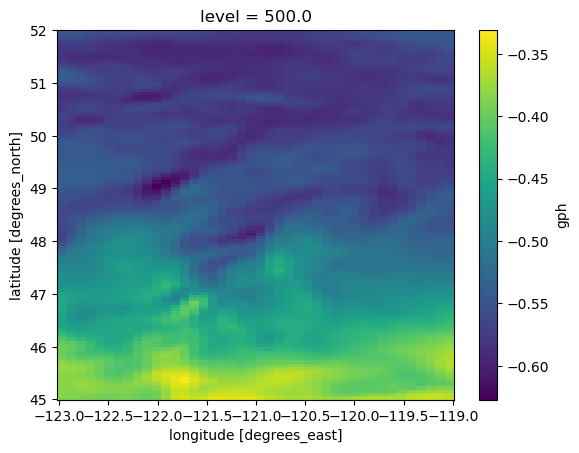

In [14]:
diff_sensgph.plot()

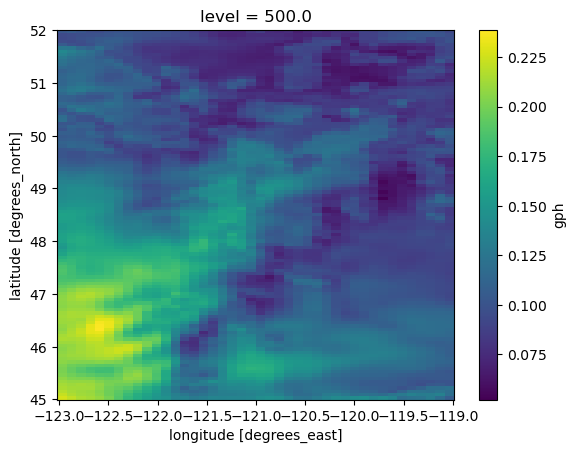

In [15]:
diff_months.plot()